In [1]:
import numpy as np
import pandas as pd

In [28]:
data = pd.read_csv('/content/spam.csv')

In [29]:
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [30]:
drop_cols = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
data.drop(drop_cols, axis=1, inplace=True)

In [31]:
data.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [33]:
data["text"] = data.v2
data["spam"] = data.v1

In [34]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2) 

In [35]:
emails_train.shape


(4457,)

In [36]:
import string
import re
import sklearn
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS


## 1. Text Processing

In [37]:
#cleaning the raw data
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [38]:
x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'remember all those whom i hurt during days of satanic imposter in meneed to pay a priceso be itmay destiny keep me going and as u said pray that i get the mind to get over the same'

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

## 2.Tokenize

In [40]:
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [41]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


[493,
 49,
 379,
 1514,
 1,
 514,
 935,
 259,
 14,
 3474,
 3475,
 8,
 3476,
 2,
 336,
 4,
 3477,
 33,
 3478,
 3479,
 221,
 10,
 72,
 7,
 75,
 6,
 149,
 1324,
 19,
 1,
 31,
 5,
 318,
 2,
 31,
 189,
 5,
 250]

## 3. Padding

In [42]:
from keras_preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ..., 189,   5, 250], dtype=int32)

## 4. Model

In [43]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [44]:
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2000, 32)          1600000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
____________________________________________

In [45]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))


Epoch 1/20
9/9 [==============================] - 7s 375ms/step - loss: 0.6268 - accuracy: 0.8656 - val_loss: 0.5046 - val_accuracy: 0.8655
Epoch 2/20
9/9 [==============================] - 3s 283ms/step - loss: 0.4251 - accuracy: 0.8661 - val_loss: 0.3701 - val_accuracy: 0.8655
Epoch 3/20
9/9 [==============================] - 3s 282ms/step - loss: 0.3729 - accuracy: 0.8661 - val_loss: 0.3511 - val_accuracy: 0.8655
Epoch 4/20
9/9 [==============================] - 3s 283ms/step - loss: 0.3240 - accuracy: 0.8661 - val_loss: 0.2938 - val_accuracy: 0.8655
Epoch 5/20
9/9 [==============================] - 3s 285ms/step - loss: 0.2355 - accuracy: 0.8705 - val_loss: 0.1933 - val_accuracy: 0.9067
Epoch 6/20
9/9 [==============================] - 3s 285ms/step - loss: 0.1438 - accuracy: 0.9630 - val_loss: 0.1391 - val_accuracy: 0.9731
Epoch 7/20
9/9 [==============================] - 3s 285ms/step - loss: 0.0986 - accuracy: 0.9827 - val_loss: 0.1042 - val_accuracy: 0.9785
Epoch 8/20
9/9 [====

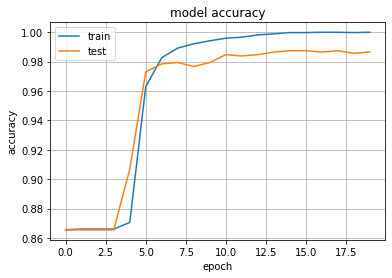

In [46]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [47]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score, accuracy_score

In [48]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]


35/35 [==============================] - 5s 111ms/step


In [49]:
cf_matrix =confusion_matrix(test_y,y_predict)


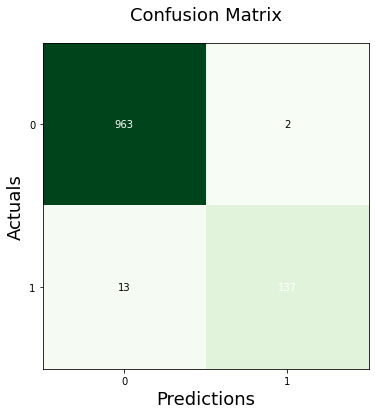

In [51]:
from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [54]:
from sklearn.metrics import classification_report

print(classification_report(test_y,y_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.99      0.91      0.95       150

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

